In [12]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
import random

import matplotlib.style as style
style.use('ggplot')

In [13]:
#Data_Unified Labels
#Cyc Water, Mill Water , Mill Feed , PSI  , Cyc Pressure , Mill Power , % Solids
data = np.loadtxt("Dados_Filtrados_Unificado_csv.csv", delimiter = ',')

x_data = data[:,0:6]
y_data = data[:,6]

In [14]:
(train_data, test_data, 
     train_targets, test_targets) = train_test_split(x_data, y_data, test_size=.4, random_state=5)

In [15]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [16]:
def build_model():
    #Building the Network:
    model = models.Sequential()
    
    #Inputs and Hidden Layers
    model.add(Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],))) # Dim = 6
    model.add(Dense(64, activation = 'relu'))
    
    #Output
    model.add(Dense(1))
    
    #Compiling the model
    model.compile(loss = "mean_squared_error", optimizer = "Adam", metrics = ['mean_absolute_error'])
    return model

In [17]:
#First fitting with 50 epochs
num_epochs = 50

#Perfmorming k-fold cross validation
k = 4
#Keep track on the time required
start = time.time()

num_val_samples = len(train_data) // k
all_scores = []

for i in range(k):
    print('Processing Fold #', i, '...')
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
end = time.time()
print("Time Elapsed:", end - start, "s")
    

Processing Fold # 0 ...
Processing Fold # 1 ...
Processing Fold # 2 ...
Processing Fold # 3 ...
Time Elapsed: 27.063935041427612 s


In [18]:
print("Mean Absolut Errors: ")
for i in range(k):
    print("Fold #",i,":", all_scores[i])

Mean Absolut Errors: 
Fold # 0 : 0.013701144605875015
Fold # 1 : 0.019678328186273575
Fold # 2 : 0.014908055774867535
Fold # 3 : 0.007668966427445412


In [19]:
print("Mean Error: ")
np.mean(all_scores)

Mean Error: 


0.013989123748615384

In [20]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Cleaning memory cached
from tensorflow.keras import backend as K
K.clear_session()

In [25]:
#Increasing number of Epochs to 800 for better perfomance
num_epochs = 500
all_mae_histories = []
start = time.time()
all_scores_improved =[]

for i in range(k):
    print('processing fold #', i, '...')
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores_improved.append(val_mae)
    
end = time.time()
print("Time Elapsed:", end - start, "s")

processing fold # 0 ...
processing fold # 1 ...
processing fold # 2 ...
processing fold # 3 ...
Time Elapsed: 382.5309863090515 s


In [26]:
print("Mean Absolut Errors for 500 epochs: ")
for i in range(k):
    print("Fold #",i,":", all_scores_improved[i])

Mean Absolut Errors for 500 epochs: 
Fold # 0 : 0.008224043063819408
Fold # 1 : 0.00928706768900156
Fold # 2 : 0.012169682420790195
Fold # 3 : 0.011618413962423801


In [28]:
print("Mean Error: ")
np.mean(all_scores_improved)

Mean Error: 


0.010324801784008741

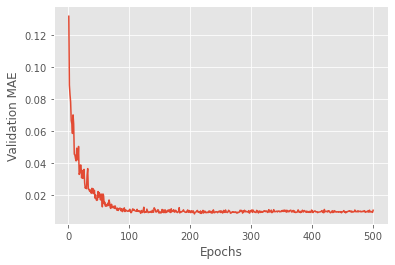

In [29]:
#Plotting the average mean absolute error
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

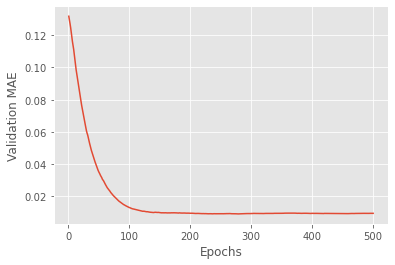

In [30]:
#Smoothing the curve for better visualization
#and using exponential moving averages instead of points
def smooth_curve(points, factor=0.95):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

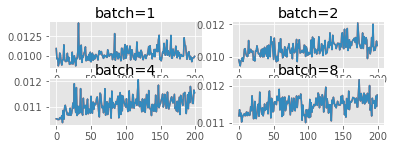

Time Elapsed: 160.13765788078308 s


In [31]:
from matplotlib import pyplot
start = time.time()
#Comparing different Batch Sizes
#Create learning curves for different batch sizes
batch_sizes = [1, 2, 4, 8]
for i in range(len(batch_sizes)):
    #Determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    n_batch = batch_sizes[i]
    #Fit model and plot learning curves for a batch size
    history = model.fit(train_data, train_targets,
                        validation_data=(test_data, test_targets),
                        epochs=200, batch_size=batch_sizes[i], verbose=0)
    pyplot.plot(history.history['val_mean_absolute_error'], label='train')
    pyplot.plot(history.history['val_mean_absolute_error'], label='test')
    pyplot.title('batch='+str(n_batch), pad=-40)
#Show learning curves
pyplot.show()
end = time.time()
print("Time Elapsed:", end - start, "s")

In [32]:
start = time.time()
#Creating a final model after tuning to test performance
model_final = build_model()
# Train it on the entirety of the data.
model_final.fit(train_data, train_targets,
          epochs=150, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
end = time.time()
print("Time elapsed: ", end-start,"s")

6/6 [==============================] - 0s 1ms/step - loss: 2.5580e-04 - mean_absolute_error: 0.0117
Time elapsed:  25.563894033432007 s


In [33]:
test_mae_score

0.0117496894672513

In [34]:
def normaliza(x_new):
    x_new[0][0] -= 221.3929
    x_new[0][1] -= 16.9675
    x_new[0][2] -= 193.2343
    x_new[0][3] -= 63.488
    x_new[0][4] -= 0.4840
    x_new[0][5] -= 3192.9

    x_new[0][0] /= 12.19024
    x_new[0][1] /= 2.048039
    x_new[0][2] /= 14.6197
    x_new[0][3] /= 3.098351
    x_new[0][4] /= 0.07179886
    x_new[0][5] /= 146.282
    
    return x_new

In [35]:
#Making predictions
#[Cyc Water, Mill Water , Mill Feed , PSI  , Cyc Pressure , Mill Power] -> % Solids

x_test = []
y_test = []

x_test.append(np.array([[230, 20, 200, 65, 0.55, 3300]]))
x_test.append(np.array([[230.7948,19.0728,199.5670,61.9917,0.4750,3096.6288]]))
x_test.append(np.array([[220.0886,15.3509,181.2426,64.7993,0.4114,3074.2701]]))
x_test.append(np.array([[9.7484,0.2655,0.2059,62.4160,0.0069,2507.2545]]))

for i in range(0,4):
    
    y_test.append(model.predict(normaliza(x_test[i])))
    print("X=%s\nY=%s \n" % (x_test[i][0], y_test[i][0]))


X=[0.70606485 1.48068469 0.46277967 0.48800152 0.91923465 0.7321475 ]
Y=[0.7914229] 

X=[ 0.77126455  1.02795894  0.4331621  -0.48293431 -0.12535018 -0.65812062]
Y=[0.7922757] 

X=[-0.10699543 -0.78934044 -0.82024255  0.42322513 -1.01115812 -0.81096717]
Y=[0.78800845] 

X=[-17.36179928  -8.15511814 -13.20330787  -0.3459905   -6.6449523
  -4.68714879]
Y=[0.85041475] 



In [29]:
print(y_data.std())

0.009976537433091884
